<a href="https://colab.research.google.com/github/KaliYuga-ai/KaliYuga-s-Library-of-Historic-AI-Tools/blob/main/ruDALLE_example_generation_w_Caching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Доступные ресурсы
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

CPU: 2
RAM GB: 12.7
PyTorch version: 1.9.0+cu111
CUDA version: 11.1
cuDNN version: 8005
device: cuda
Tue Nov  2 08:07:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-----------

In [ ]:
!pip install git+https://github.com/sberbank-ai/ru-dalle > /dev/null #The PR just got merged into master

In [ ]:
from rudalle.pipelines import generate_images, show, super_resolution, cherry_pick_by_clip
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan, get_ruclip
from rudalle.utils import seed_everything

In [ ]:
device = 'cuda'
dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)

Downloading:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.


In [ ]:
realesrgan = get_realesrgan('x4', device=device)
tokenizer = get_tokenizer()
vae = get_vae().to(device)
ruclip, ruclip_processor = get_ruclip('ruclip-vit-base-patch32-v5')
ruclip = ruclip.to(device)

Downloading:   0%|          | 0.00/67.0M [00:00<?, ?B/s]

x4 --> ready


Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

vae --> ready


Downloading:   0%|          | 0.00/748k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.14k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

ruclip --> ready


## generation by ruDALLE

In [ ]:
text = 'изображение радуги на фоне ночного города'
pil_images = []
scores = []

seed_everything(42)

for top_k, top_p, images_num in [
    (2048, 0.995, 3),
    (1536, 0.99, 3),
    (1024, 0.99, 3),
    (1024, 0.98, 3),
    (512, 0.97, 3),
    (384, 0.96, 3),
    (256, 0.95, 3),
    (128, 0.95, 3), 
]:
    _pil_images, _scores = generate_images(text, tokenizer, dalle, vae, top_k=top_k, images_num=images_num, top_p=top_p)
    pil_images += _pil_images
    scores += _scores

  0%|          | 1/1024 [00:02<37:54,  2.22s/it]/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
 82%|████████▏ | 836/1024 [05:24<01:47,  1.76it/s]

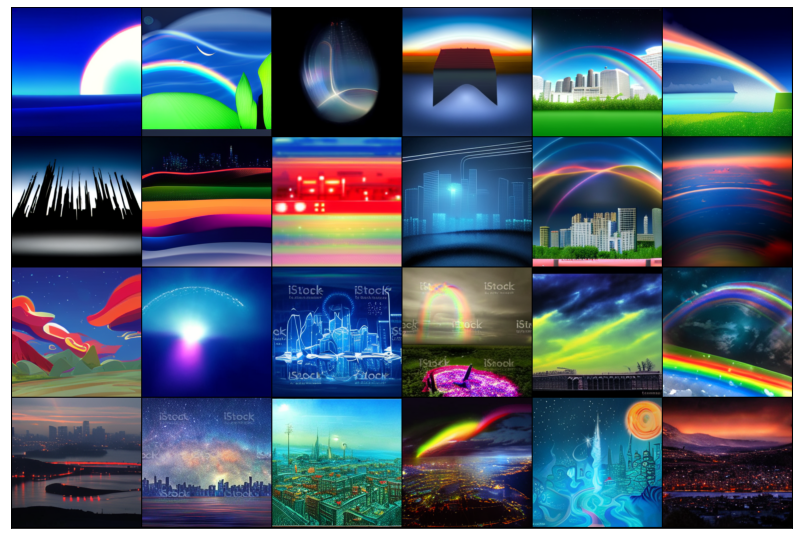

In [ ]:
show([pil_image for pil_image, score in sorted(zip(pil_images, scores), key=lambda x: -x[1])] , 6)

### auto-cherry-pick by ruCLIP

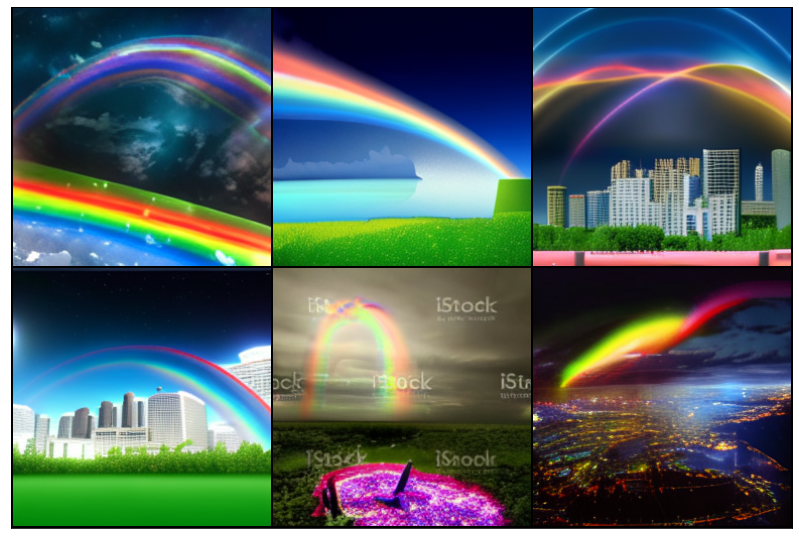

In [ ]:
top_images, clip_scores = cherry_pick_by_clip(pil_images, text, ruclip, ruclip_processor, device=device, count=6)
show(top_images, 3)

## super resolution

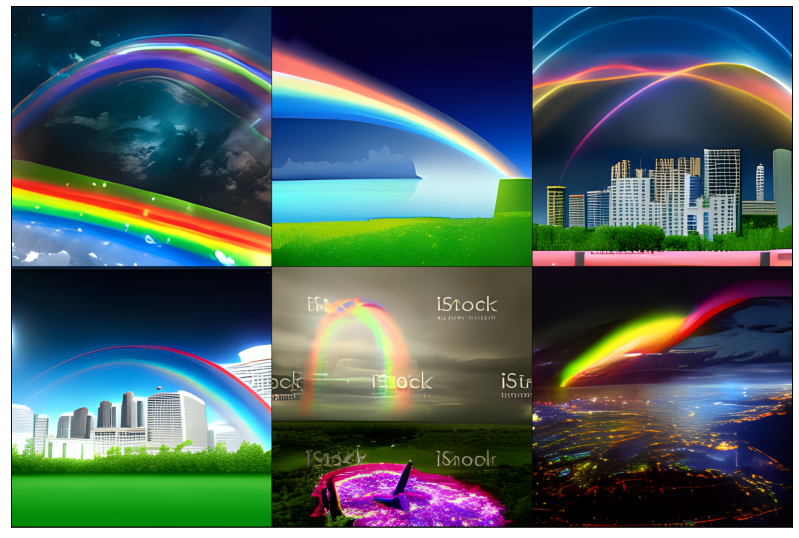

In [ ]:
sr_images = super_resolution(top_images, realesrgan)
show(sr_images, 3)